# MODIS



MODIS Terra: https://lpdaac.usgs.gov/products/mod11c1v006/

MODIS Acqua: https://lpdaac.usgs.gov/products/myd11c1v061/

Docs: https://lpdaac.usgs.gov/documents/118/MOD11_User_Guide_V6.pdf

In [1]:
! wget https://e4ftl01.cr.usgs.gov/MOLA/MYD11C1.061/2018.04.19/MYD11C1.A2018109.061.2021330052306.hdf -O /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/MODIS.hdf

--2022-03-18 11:14:00--  https://e4ftl01.cr.usgs.gov/MOLA/MYD11C1.061/2018.04.19/MYD11C1.A2018109.061.2021330052306.hdf
Resolving e4ftl01.cr.usgs.gov (e4ftl01.cr.usgs.gov)... 152.61.133.130, 2001:49c8:4000:127d::133:130
Connecting to e4ftl01.cr.usgs.gov (e4ftl01.cr.usgs.gov)|152.61.133.130|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://urs.earthdata.nasa.gov/oauth/authorize?scope=uid&app_type=401&client_id=ijpRZvb9qeKCK5ctsn75Tg&response_type=code&redirect_uri=https%3A%2F%2Fe4ftl01.cr.usgs.gov%2Foauth&state=aHR0cHM6Ly9lNGZ0bDAxLmNyLnVzZ3MuZ292L01PTEEvTVlEMTFDMS4wNjEvMjAxOC4wNC4xOS9NWUQxMUMxLkEyMDE4MTA5LjA2MS4yMDIxMzMwMDUyMzA2LmhkZg [following]
--2022-03-18 11:14:08--  https://urs.earthdata.nasa.gov/oauth/authorize?scope=uid&app_type=401&client_id=ijpRZvb9qeKCK5ctsn75Tg&response_type=code&redirect_uri=https%3A%2F%2Fe4ftl01.cr.usgs.gov%2Foauth&state=aHR0cHM6Ly9lNGZ0bDAxLmNyLnVzZ3MuZ292L01PTEEvTVlEMTFDMS4wNjEvMjAxOC4wNC4xOS9NWUQxMUMxLkEyMDE4MTA5LjA2

In [2]:
import xarray as xr
import rioxarray as rxr

modis_xarray= rxr.open_rasterio('/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/MODIS.hdf',masked=True)

In [54]:
modis_xarray['Day_view_time']

<xarray.DataArray 'Day_view_time' (band: 1, y: 3600, x: 7200)>
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]], dtype=float32)
Coordinates:
  * y            (y) float64 89.97 89.92 89.88 89.82 ... -89.88 -89.93 -89.98
  * x            (x) float64 -180.0 -179.9 -179.9 -179.8 ... 179.9 179.9 180.0
  * band         (band) int64 1
    spatial_ref  int64 0
Attributes:
    scale_factor:  0.2
    add_offset:    0.0
    long_name:     Time of daytime LST observation (UTC)
    units:         hrs

In [35]:
modis_df = modis_xarray.to_dataframe().reset_index()

In [41]:
lite = modis_df[['y','x', 'LST_Day_CMG','Day_view_time', 'LST_Night_CMG', 'Night_view_time']]

In [48]:
L = lite.dropna().copy()

In [59]:
L['T_Day'] = L['LST_Day_CMG']*0.02
L['T_Night'] = L['LST_Night_CMG']*0.02
L['Time_Day'] = L['Day_view_time']*0.2
L['Time_Night'] = L['Night_view_time']*0.2
L['Time_Day_UTC'] = L['Time_Day'] - L['x']/15

In [192]:
window = L.query('-70 < y < 70')

In [193]:
w = window.copy()

In [194]:
import pandas as pd
    
#Create time delta to change local to UTC
#time_delta = pd.to_timedelta(window.x/15,unit='H') 
    
    #Convert local satellite time to UTC and round to nearest hour
   # time = (pd.to_datetime([file_date + " " + local_times[satellite]]*time_delta.shape[0]) - time_delta).round('H')


w['ideal_UTC'] = (pd.to_datetime("2022-01-01 13:30") - pd.to_timedelta(w.x/15))#.dt.time
w['actual_utc'] = (pd.to_datetime("2022-01-01 00:00") + pd.to_timedelta(w.Time_Day_UTC,unit='hours'))#.dt.time    
#w['dfdf'] = w.ideal_UTC.dt.time
#w['actual_utc'] = (pd.to_datetime("00:00") + pd.to_timedelta(w.Time_Day_UTC,unit='hours')).dt.time                   #.dt.components['hours']

In [195]:
w['difference'] = pd.to_timedelta(w.ideal_UTC - w.actual_utc,unit='s').dt.total_seconds() / 60

In [200]:
w

,y,x,LST_Day_CMG,Day_view_time,LST_Night_CMG,Night_view_time,T_Day,T_Night,Time_Day,Time_Night,Time_Day_UTC,ideal_UTC,actual_utc,difference
2880342,69.975,-162.875,13025.0,118.0,12595.0,64.0,260.500000,251.899994,23.6,12.8,34.458334,2022-01-01 13:30:00.000000010,2022-01-02 10:27:30.001374000,-1257.500023
2880343,69.975,-162.825,13025.0,118.0,12595.0,64.0,260.500000,251.899994,23.6,12.8,34.455000,2022-01-01 13:30:00.000000010,2022-01-02 10:27:18.001371600,-1257.300023
2880344,69.975,-162.775,13025.0,118.0,12595.0,64.0,260.500000,251.899994,23.6,12.8,34.451667,2022-01-01 13:30:00.000000010,2022-01-02 10:27:06.001372800,-1257.100023
2880345,69.975,-162.725,13025.0,118.0,12595.0,64.0,260.500000,251.899994,23.6,12.8,34.448334,2022-01-01 13:30:00.000000010,2022-01-02 10:26:54.001374000,-1256.900023
2880346,69.975,-162.675,13025.0,118.0,12595.0,64.0,260.500000,251.899994,23.6,12.8,34.445000,2022-01-01 13:30:00.000000010,2022-01-02 10:26:42.001371600,-1256.700023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23039603,-69.975,160.175,12366.0,17.0,12820.0,65.0,247.319992,256.399994,3.4,13.0,-7.278333,2022-01-01 13:29:59.999999990,2021-12-31 16:43:18.000343201,1246.699994
23039604,-69.975,160.225,12413.0,16.0,12789.0,65.0,248.259995,255.779999,3.2,13.0,-7.481667,2022-01-01 13:29:59.999999990,2021-12-31 16:31:06.000171600,1258.899997
23039605,-69.975,160.275,12413.0,16.0,12789.0,65.0,248.259995,255.779999,3.2,13.0,-7.485000,2022-01-01 13:29:59.999999990,2021-12-31 16:30:54.000172800,1259.099997
23039606,-69.975,160.325,12413.0,16.0,12789.0,65.0,248.259995,255.779999,3.2,13.0,-7.488333,2022-01-01 13:29:59.999999990,2021-12-31 16:30:42.000170400,1259.299997


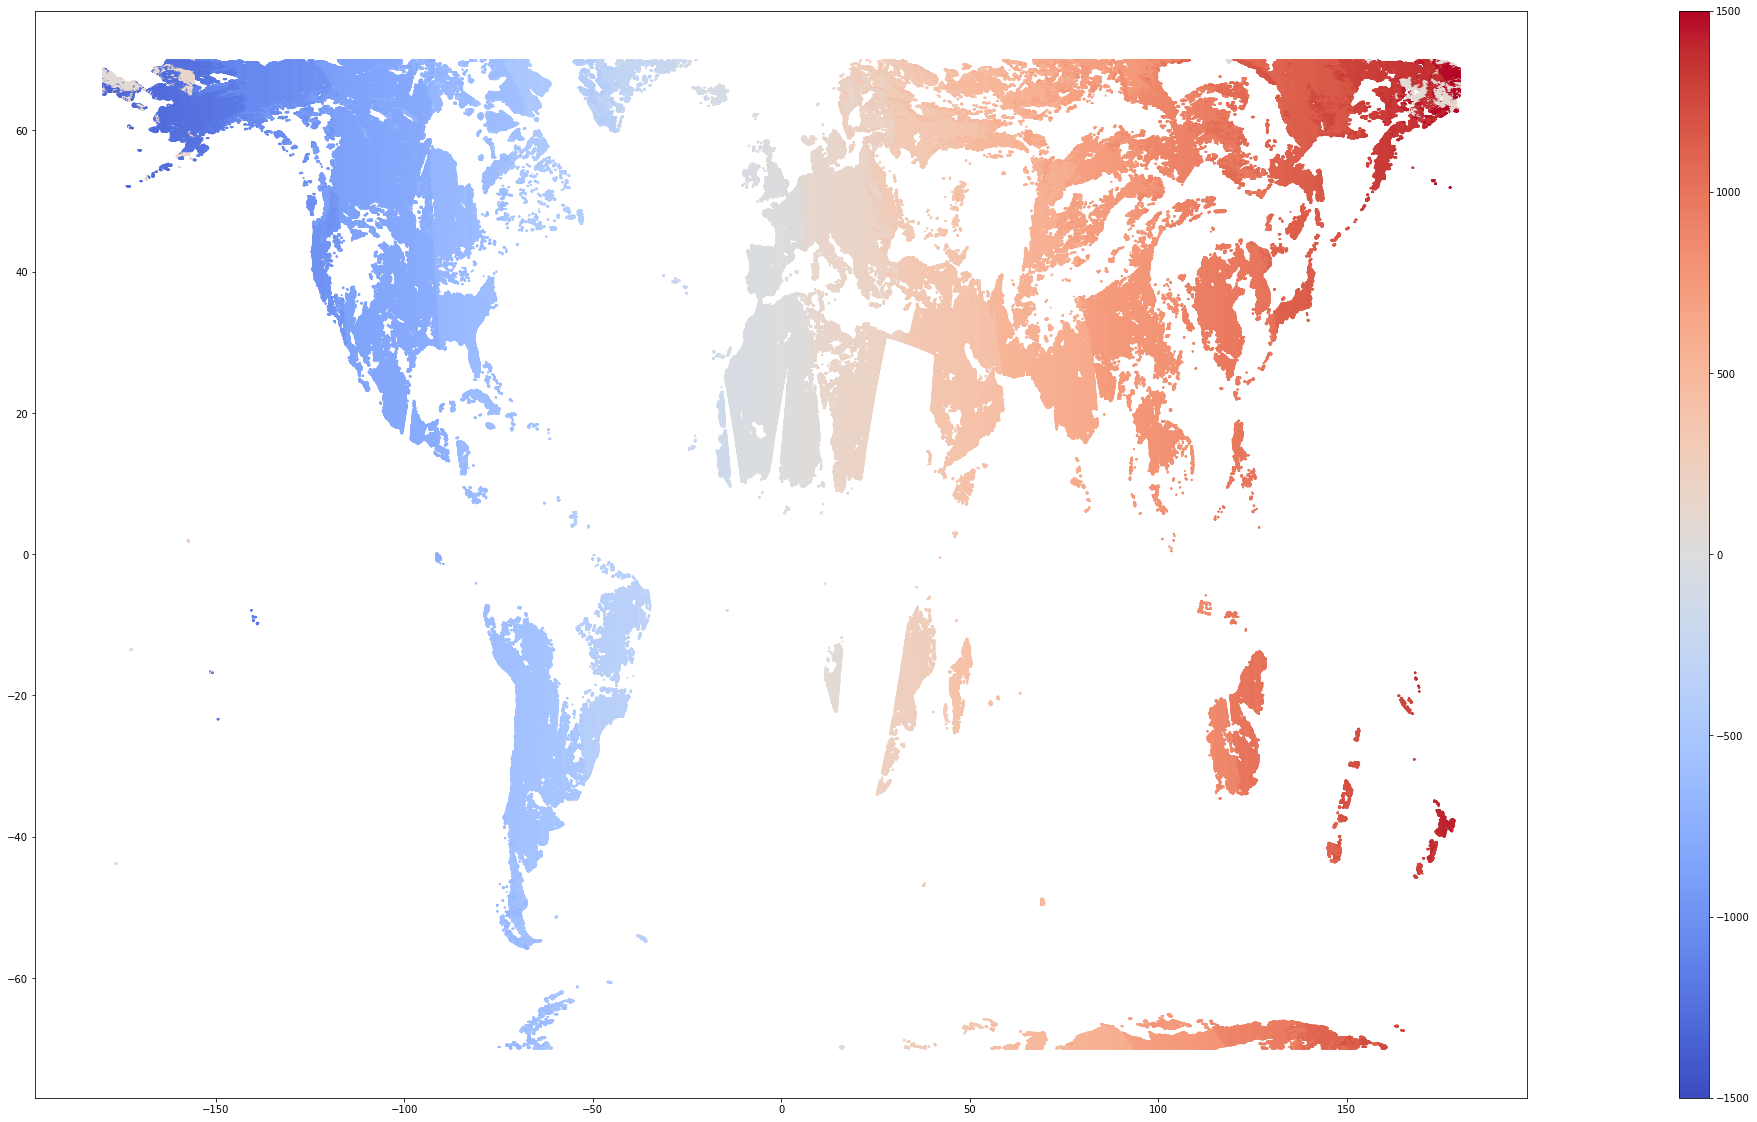

In [199]:
import matplotlib.pyplot as plt
import matplotlib.colors as mc
import matplotlib.colorbar as cb  

#Get all data as vectors
x = w.x.values
y = w.y.values
z1 = w.difference.values

cmap = plt.cm.coolwarm
#Scatter plot it
# init the figure
fig,[ax,cax] = plt.subplots(1,2, gridspec_kw={"width_ratios":[50,1]},figsize=(30, 20))

vmin = -1500
vmax= +1500
norm = mc.Normalize(vmin=vmin, vmax=vmax)

cb1 = cb.ColorbarBase(cax, cmap=cmap,norm=norm,orientation='vertical')
    
    
sc = ax.scatter(x, y,s=1,c=cmap(norm(z1)),linewidths=1, alpha=1)

#ax.set_title(z)
plt.show()

In [32]:
modis_xarray.LST_Day_CMG.data.dropna()

AttributeError: 'numpy.ndarray' object has no attribute 'dropna'

In [11]:
t = modis_xarray.Day_view_time.data

In [15]:
tt = t.flatten()

In [16]:
sum(tt)

nan

In [25]:
import numpy as np
tnn = t[~np.isnan(t)]*0.2

In [26]:
len(tnn)

6429550

In [27]:
min(tnn)

0.0

In [28]:
max(tnn)

24.0

In [29]:
np.unique(tnn)

array([ 0.       ,  0.2      ,  0.4      ,  0.6      ,  0.8      ,
        1.       ,  1.2      ,  1.4      ,  1.6      ,  1.8000001,
        2.       ,  2.2      ,  2.4      ,  2.6000001,  2.8      ,
        3.       ,  3.2      ,  3.4      ,  3.6000001,  3.8      ,
        4.       ,  4.2000003,  4.4      ,  4.6      ,  4.8      ,
        5.       ,  5.2000003,  5.4      ,  5.6      ,  5.8      ,
        6.       ,  6.2000003,  6.4      ,  6.6      ,  6.8      ,
        7.       ,  7.2000003,  7.4      ,  7.6      ,  7.8      ,
        8.       ,  8.2      ,  8.400001 ,  8.6      ,  8.8      ,
        9.       ,  9.2      ,  9.400001 ,  9.6      ,  9.8      ,
       10.       , 10.2      , 10.400001 , 10.6      , 10.8      ,
       11.       , 11.2      , 11.400001 , 11.6      , 11.8      ,
       12.       , 12.2      , 12.400001 , 12.6      , 12.8      ,
       13.       , 13.2      , 13.400001 , 13.6      , 13.8      ,
       14.       , 14.2      , 14.400001 , 14.6      , 14.8   

In [ ]:
[[[-19.0715515614,-1.4393790966],
  [53.2624328136,-1.4393790966],
  [53.2624328136,36.0044133726],
  [-19.0715515614,36.0044133726],
  [-19.0715515614,-1.4393790966]]]

In [ ]:
-19 56


-1.4 36